<a href="https://colab.research.google.com/github/RonanBERDY/AI-Enhanced-Snake-Optimizer/blob/main/lucianschwartz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Module to install

In [4]:
import numpy as np
from scipy.optimize import minimize
import ruptures as rpt
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from scipy.interpolate import interp1d


In [3]:
pip install ruptures

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 17.9 MB/s eta 0:00:00


Load the historical spot price of Romanian Power

In [6]:
roumanie = pd.read_excel("serie_ro.xlsx")
roumanie.columns = roumanie.columns.str.strip()
S = roumanie["power.ro.price.day_ahead.euromwh.daily.obs.cet"].astype(float).dropna().reset_index(drop=True)
dates = pd.to_datetime(roumanie["Date"], dayfirst=True)  # dayfirst=True for format DD-MM-YYYY

# Create DataFrame
df = pd.DataFrame({"Date": dates, "Spot": S})
df.dropna(inplace=True)

# Set Date as index
df.set_index('Date', inplace=True)

The idea is to decompose the spot price using the two-factor model of Lucien Schwartz as follows:

 - 𝑆𝑡=exp(𝑓(𝑡)+𝑋𝑡+𝑌𝑡)

 where 𝑓(𝑡) is a seasonality function, and the two latent factors 𝑋𝑡 and 𝑌𝑡 satisfy the following stochastic differential equations:

 - 𝑋𝑡 is a short-term factor following a mean-reverting Ornstein-Uhlenbeck process:

   - 𝑑𝑋𝑡=−𝜅𝑋𝑡𝑑𝑡+𝜎𝑋𝑑𝑊𝑡,

 - 𝑌𝑡 is a long-term factor (or drift term):

   - 𝑑𝑌𝑡=𝜇𝑑𝑡+𝜎𝑌𝑑𝑊y𝑡.

Equivalently, taking the natural logarithm, we have:

 - Ln(𝑆𝑡)=𝑓(𝑡)+𝑋𝑡+𝑌𝑡

To estimate the seasonal component 𝑓(𝑡) from historical data, we can use the STL decomposition in Python.

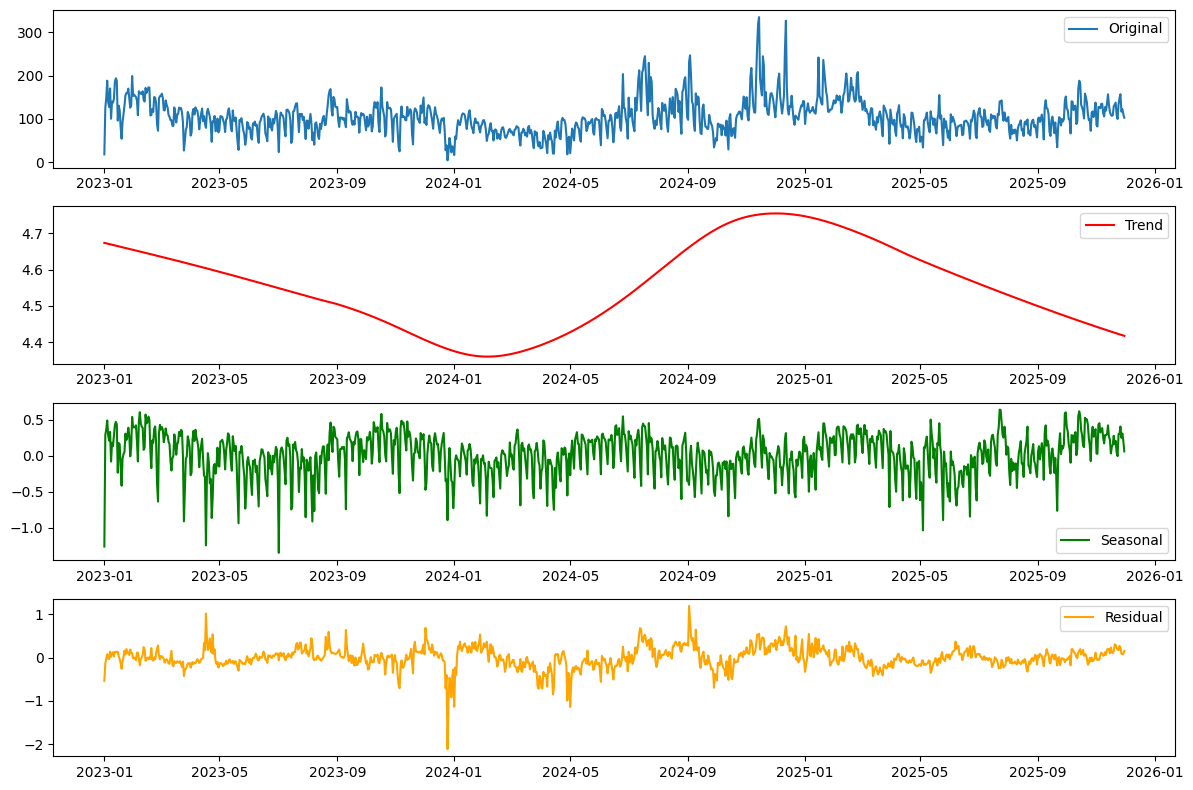

In [7]:
stl = STL(np.log(df['Spot']), period=252)
result = stl.fit()

# Extract trend, seasonal, residual
trend = result.trend
seasonal = result.seasonal
residual = result.resid

# Plot
plt.figure(figsize=(12,8))
plt.subplot(4,1,1)
plt.plot(df['Spot'], label='Original')
plt.legend()
plt.subplot(4,1,2)
plt.plot(trend, label='Trend', color='red')
plt.legend()
plt.subplot(4,1,3)
plt.plot(seasonal, label='Seasonal', color='green')
plt.legend()
plt.subplot(4,1,4)
plt.plot(residual, label='Residual', color='orange')
plt.legend()
plt.tight_layout()
plt.show()

We can extract the repeating annual pattern, represented by the seasonal component𝑓(𝑡), and compute the deseasonalized spot price, denoted as Y𝑡. This gives :     
 - Log(St)= 𝑋𝑡 + 𝑌𝑡

and we will use a breakpoint to identify potential structural changes in the series

Breaking Point : [550, 1065]
Segment 1 : 2023-01-01 00:00:00 → 2024-07-03 00:00:00
Segment 2 : 2024-07-04 00:00:00 → 2025-11-30 00:00:00


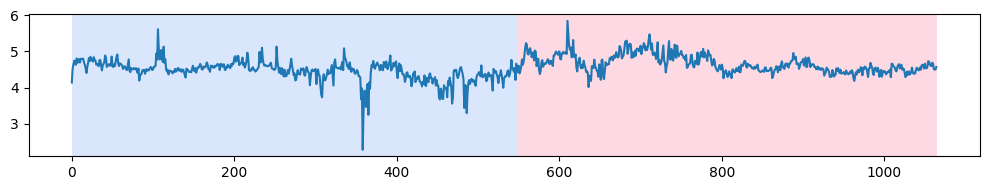

In [16]:
Y = np.log(df["Spot"]) - seasonal
y = Y.values   # ruptures attend des numpy arrays

# Model : "l2"
algo = rpt.Binseg(model="l2").fit(y)

# 1 rupture → Lucia–Schwarz = looking for the best break
bkps = algo.predict(n_bkps=1)

print("Breaking Point :", bkps)

# Break it down
break_index = bkps[0]

segment_1 = Y.iloc[:break_index]
segment_2 = Y.iloc[break_index:]

print("Segment 1 :", segment_1.index[0], "→", segment_1.index[-1])
print("Segment 2 :", segment_2.index[0], "→", segment_2.index[-1])
rpt.display(y, bkps)
plt.show()

We define:
- State vector:
  - Z_t = [X_t, Y_t]
- Observation:
  - y_t = log(S_t) = X_t + Y_t + noise

The state equations are:

- X_{t+Δt} =  X_t * exp(-𝜅Δt) + η_X

- Y_{t+Δt} = Y_t + μ * Δt + η_Y

So we have the following transition matrix :    
- F = [[exp(-𝜅Δt), 0] ,[0, 1]]
 - η_t = [η_X , η_Y + μ * Δt ]

 We have the folloing variance of Xt and Yt:

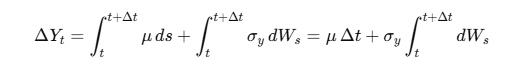

Then :    
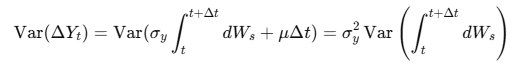

Including the propriety of a Brownian Motion we have :    
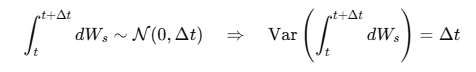

From this we find Qy and using the similar method we find Qx.

 - Qx = (𝜎x/2𝜅)*(1 - exp(-2𝜅Δt))
 - Qy =  𝜎y^2 * Δt
 - Q = [[Qx 0],[0 Qy]]

 Initialization
We start with an initial guess of the system’s state (x0) and our uncertainty about it (P0).

Prediction
Using our model, we predict what the next state should be (x_pred) and how uncertain we are about it (P_pred).

Compare with the observation
We take the actual measurement (z[t]) and compare it to our prediction (z_pred).
The difference is called the innovation.

Kalman Gain
The Kalman Gain K tells us how much we should trust the observation versus the prediction.

If K is large → we trust the observation more

If K is small → we trust the model more

Update the state
We correct our state estimate using the innovation and the Kalman Gain:

This gives the best estimate combining model + measurement.

Update uncertainty
After seeing the observation, we update our uncertainty:

The uncertainty usually decreases, because the observation gives us more information.

Prepare for the next step
We predict the next state again using our model:

Repeat for all measurements
We do this step by step for every observation, updating the state and its uncertainty each time.

Log-likelihood accumulation
At each step, we calculate how probable the observation is given our prediction (loglik).

This tells us how well the model explains the data.

Later, we can optimize model parameters by maximizing this likelihood.

In [17]:

def phi_from_kappa(kappa, dt=1.0):

    return np.exp(-kappa * dt)

def var_ou_stationary(kappa, sigma_x):
    # stationary variance of OU: sigma_x^2 / (2*kappa)
    return sigma_x**2 / (2.0 * kappa)

def q_x_discrete(kappa, sigma_x, dt=1.0):
    # variance of discrete innovation of OU over dt:
    phi = phi_from_kappa(kappa, dt)
    # Var(epsilon) = Var(X_t) * (1 - phi^2) where Var(X_t) = sigma_x^2/(2α)
    return (sigma_x**2 / (2.0 * kappa)) * (1.0 - phi**2)

# --- Kalman filter  ---
def kalman_loglike(params_transformed, z):
    """
    params_transformed ensures positivity for certain params via exponent.
    params_transformed = [log_kappa, log_sigma_x, mu, log_sigma_y, log_sigma_eps]
    z: numpy array of observations (Y deseasonalized)
    """
    # unpack and transform
    log_kappa, log_sigma_x, mu, log_sigma_y, log_sigma_eps = params_transformed
    kappa = np.exp(log_kappa)
    sigma_x = np.exp(log_sigma_x)
    sigma_y = np.exp(log_sigma_y)
    sigma_eps = np.exp(log_sigma_eps)
    dt = 1.0  # daily

    phi_x = phi_from_kappa(kappa, dt)

    # state transition matrix F and control (drift) vector c
    F = np.array([[phi_x, 0.0],
                  [0.0,   1.0]])
    c = np.array([0.0, mu])  # additive drift to state

    # process noise covariance Q (2x2 diag)
    q_x = q_x_discrete(kappa, sigma_x, dt)
    q_y = (sigma_y**2) * dt
    Q = np.array([[q_x, 0.0],
                  [0.0, q_y]])

    # observation matrix H (z_t = X_t + Y_t + eps)
    H = np.array([[1.0, 1.0]])  # 1x2

    R = np.array([[sigma_eps**2]])  # observation noise variance

    T = len(z)

    # initial state and covariance: set to stationary for X and zero-mean for Y
    x0 = np.array([0.0, z[0]])  # init X=0, Y approximated by first obs
    P0 = np.diag([var_ou_stationary(kappa, sigma_x), 1.0])  # crude init variance for Y

    x_pred = x0.copy()
    P_pred = P0.copy()

    loglik = 0.0
    small = 1e-9

    for t in range(T):
        # prediction already in x_pred, P_pred
        # observation prediction
        z_pred = H @ x_pred  # scalar
        S = H @ P_pred @ H.T + R  # scalar 1x1
        # ensure S positive
        S_scalar = float(S[0,0])
        if S_scalar <= 0:
            S_scalar = small

        # innovation
        y_t = z[t] - float(z_pred)

        # Kalman gain
        K = P_pred @ H.T / S_scalar  # 2x1

        # update
        x_upd = x_pred + (K.flatten() * y_t)
        P_upd = P_pred - K @ H @ P_pred

        # accumulate log-likelihood (Gaussian)
        loglik += -0.5 * (np.log(2*np.pi) + np.log(S_scalar) + (y_t**2) / S_scalar)

        # predict next
        x_pred = F @ x_upd + c
        P_pred = F @ P_upd @ F.T + Q

    # we maximize loglik, but optimizer minimizes -> return negative
    return -loglik

In [18]:

# --- Wrapper to fit model ---
def fit_lucia_schwartz(Y_series):
    z = Y_series.values.astype(float)
    # initial guesses (in transformed space)
    # kappa ~ 0.5, sigma_x ~ std*0.5, mu ~ mean diff, sigma_y ~ std*0.5, sigma_eps small
    init_kappa = 0.5
    init_sigma_x = np.std(z) * 0.5 + 1e-6
    # mu initial from average increment
    init_mu = np.mean(np.diff(z))
    init_sigma_y = np.std(np.diff(z)) * 0.5 + 1e-6
    init_sigma_eps = max(1e-3, 0.1 * np.std(z))

    x0 = np.array([np.log(init_kappa), np.log(init_sigma_x), init_mu,
                   np.log(init_sigma_y), np.log(init_sigma_eps)])

    bounds = [(np.log(1e-6), np.log(10.0)),   # kappa
              (np.log(1e-8), np.log(10.0)),   # sigma_x
              (None, None),                   # mu
              (np.log(1e-8), np.log(10.0)),   # sigma_y
              (np.log(1e-8), np.log(10.0))]   # sigma_eps

    res = minimize(kalman_loglike, x0, args=(z,), bounds=bounds, method='L-BFGS-B',
                   options={'disp': True, 'maxiter': 200})

    if not res.success:
        print("Warning: optimisation did not converge:", res.message)

    # transform back
    log_kappa, log_sigma_x, mu_hat, log_sigma_y, log_sigma_eps = res.x
    kappa_hat = np.exp(log_kappa)
    sigma_x_hat = np.exp(log_sigma_x)
    sigma_y_hat = np.exp(log_sigma_y)
    sigma_eps_hat = np.exp(log_sigma_eps)

    # compute smoothed states via one Kalman pass + Rauch–Tung–Striebel smoother (simple forward/backward)
    # We'll do forward filter store and a backward smoother
    dt = 1.0
    phi_x = phi_from_kappa(kappa_hat, dt)
    F = np.array([[phi_x, 0.0],
                  [0.0,   1.0]])
    c = np.array([0.0, mu_hat])
    q_x = q_x_discrete(kappa_hat, sigma_x_hat, dt)
    q_y = (sigma_y_hat**2) * dt
    Q = np.array([[q_x, 0.0],
                  [0.0, q_y]])
    H = np.array([[1.0, 1.0]])
    R = np.array([[sigma_eps_hat**2]])

    T = len(z)
    # storage
    x_pred_list = np.zeros((T, 2))
    P_pred_list = np.zeros((T, 2, 2))
    x_filt_list = np.zeros((T, 2))
    P_filt_list = np.zeros((T, 2, 2))

    # init
    x_pred = np.array([0.0, z[0]])
    P_pred = np.diag([var_ou_stationary(kappa_hat, sigma_x_hat), 1.0])

    for t in range(T):
        # update
        z_pred = H @ x_pred
        S = H @ P_pred @ H.T + R
        S_scalar = float(S[0,0])
        K = P_pred @ H.T / S_scalar
        y_t = z[t] - float(z_pred)
        x_upd = x_pred + (K.flatten() * y_t)
        P_upd = P_pred - K @ H @ P_pred

        x_filt_list[t] = x_upd
        P_filt_list[t] = P_upd
        x_pred_list[t] = x_pred
        P_pred_list[t] = P_pred

        # predict next
        x_pred = F @ x_upd + c
        P_pred = F @ P_upd @ F.T + Q

    # RTS smoother (backward)
    x_smooth = np.zeros_like(x_filt_list)
    P_smooth = np.zeros_like(P_filt_list)
    x_smooth[-1] = x_filt_list[-1]
    P_smooth[-1] = P_filt_list[-1]

    for t in range(T-2, -1, -1):
        P_f = P_filt_list[t]
        P_p1 = P_pred_list[t+1]
        # compute smoother gain
        C = P_f @ F.T @ np.linalg.inv(P_p1)
        x_smooth[t] = x_filt_list[t] + C @ (x_smooth[t+1] - x_pred_list[t+1])
        P_smooth[t] = P_f + C @ (P_smooth[t+1] - P_p1) @ C.T

    # build series for smoothed factors
    idx = Y_series.index
    X_smooth = pd.Series(x_smooth[:,0], index=idx)
    Y_smooth = pd.Series(x_smooth[:,1], index=idx)

    results = {
        'kappa': kappa_hat,
        'sigma_x': sigma_x_hat,
        'mu': mu_hat,
        'sigma_y': sigma_y_hat,
        'sigma_eps': sigma_eps_hat,
        'X_smooth': X_smooth,
        'Y_smooth': Y_smooth,
        'res': res
    }
    return results

In [19]:
results = fit_lucia_schwartz(Y)



# Parameters from Lucia-Schwartz fit
kappa = results["kappa"]
sigma_x = results["sigma_x"]
mu     = results["mu"]
sigma_y = results["sigma_y"]

/tmp/ipython-input-2721437814.py:22: DeprecationWarning: scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.
  res = minimize(kalman_loglike, x0, args=(z,), bounds=bounds, method='L-BFGS-B',
/tmp/ipython-input-3877760710.py:71: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_t = z[t] - float(z_pred)
/tmp/ipython-input-2721437814.py:66: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_t = z[t] - float(z_pred)


Analyses of the parameters :    


In [20]:
print(f"kappa: {kappa}")
print(f"sigma_x: {sigma_x}")
print(f"mu: {mu}")
print(f"sigma_y: {sigma_y}")

kappa: 1.154257511010858
sigma_x: 0.21433288610952617
mu: 9.46203617945222e-05
sigma_y: 0.05960659542682643


/tmp/ipython-input-4265395625.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Y0 = np.log(df['Spot'].iloc[-1]) - seasonal[-1]


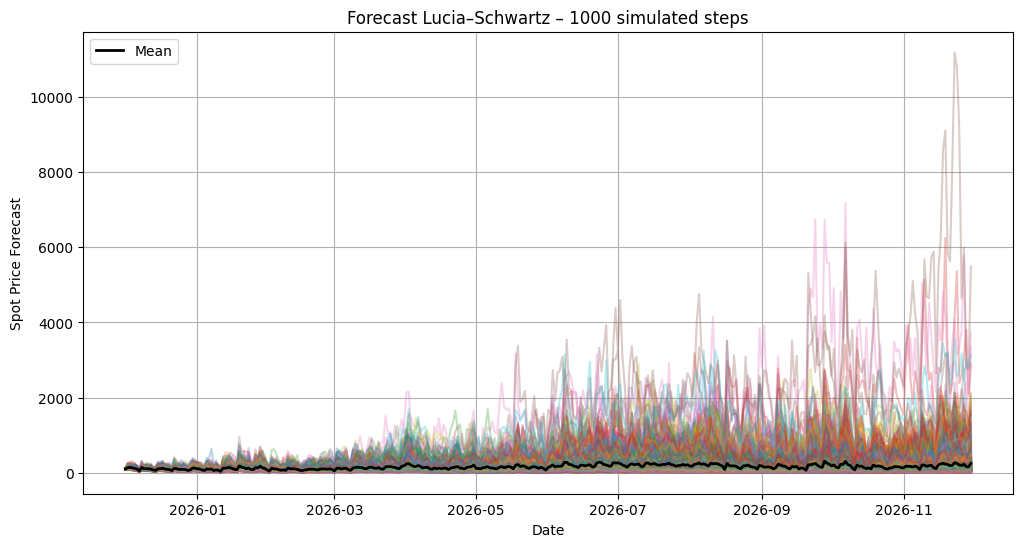

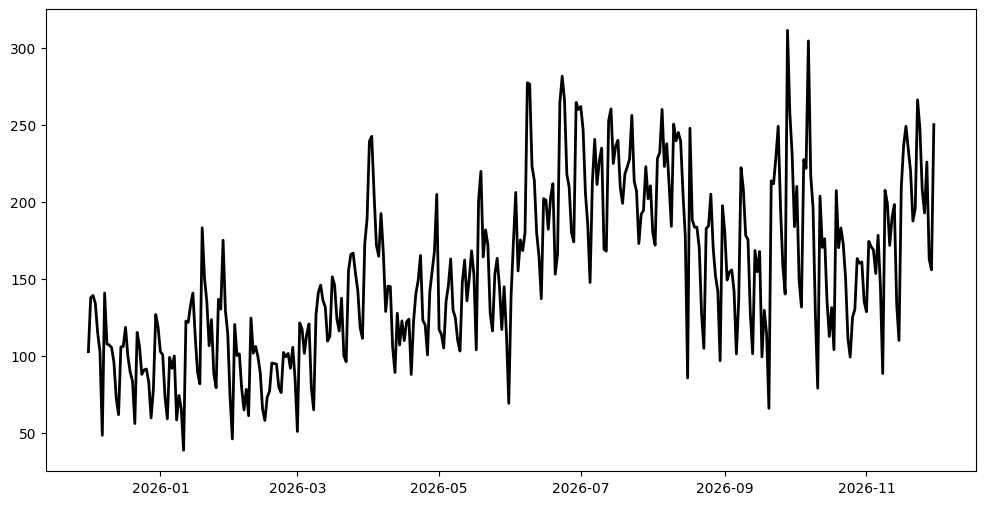

In [43]:

# Forecast Horizon
years=1
forecast_days = 365*years
N = 1000              # paths number
dt = 1                  # daily steps

# Last values of X and Y as initial values
X0 = 0
Y0 = np.log(df['Spot'].iloc[-1]) - seasonal[-1]

# Build the next season
season_future = np.tile(seasonal[-252*years:].values, int(np.ceil(forecast_days/252*years)))[:forecast_days]

X_forecast = np.zeros((N, forecast_days))
Y_forecast = np.zeros((N, forecast_days))
S_forecast = np.zeros((N, forecast_days))

X_forecast[:,0] = X0
Y_forecast[:,0] = Y0
S_forecast[:, 0] = np.exp(X_forecast[:, 0] + Y_forecast[:, 0] + seasonal.iloc[-1])
# Generation of the noise
Wx = np.random.normal(0, sigma_x * np.sqrt(dt), size=(N, forecast_days-1))
Wy = np.random.normal(0, sigma_y * np.sqrt(dt), size=(N, forecast_days-1))
all_losses=[]
worst_VaR=0
# Simulation
for t in range(1, forecast_days):
    X_forecast[:, t] = X_forecast[:, t-1] * np.exp(-kappa*dt) + Wx[:, t-1]
    Y_forecast[:, t] = Y_forecast[:, t-1] + mu*dt + Wy[:, t-1]
    S_forecast[:, t] = np.exp(X_forecast[:, t] + Y_forecast[:, t] + season_future[t])

# Creation of future index
last_date = df.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=forecast_days, freq='D')

# Plot
plt.figure(figsize=(12,6))
for i in range(N):
    plt.plot(future_dates, S_forecast[i], alpha=0.3)

# Compute the mean
S_mean = S_forecast.mean(axis=0)

# Plot the mean
plt.plot(future_dates, S_mean, color="black", linewidth=2, label="Mean")
plt.title(f"Forecast Lucia–Schwartz – {N} simulated steps")
plt.xlabel("Date")
plt.ylabel("Spot Price Forecast")
plt.grid(True)
plt.legend()
plt.show()
plt.figure(figsize=(12,6))
plt.plot(future_dates, S_mean, color="black", linewidth=2, label="Mean")
plt.show()